In [1]:
# Import packages
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from matplotlib.pylab import rcParams
import itertools
import numpy as np
import tqdm
from tqdm._tqdm_notebook import tqdm_notebook
from fbprophet import Prophet


# Preferred settings
warnings.simplefilter("ignore")


<ipython-input-1-057088e0c8b3>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


In [2]:
# Import saved data
df_TS = pd.read_csv('Data/df_TS.csv')

# Set date column to datetime object
df_TS['Date'] = pd.to_datetime(df_TS['Date'])

# Set date column as index
df_TS.set_index('Date', inplace=True)

# Prepare Data

In [3]:
# Only use pre-COVID data for time series modeling
df_TS_preCOV = df_TS.loc[:'2020-3-13']


In [4]:
# Create df of only Queens data, remove all columns other than accident counts 
df_prophet = df_TS_preCOV.drop(columns = ['Injuries', 'Deaths','Accidents_Bx', 'Accidents_Man', 'Accidents_Bkln', 'Accidents_SI',
                               'Accidents_Total','Season','Day of Week', 'Weekend','Holiday'])

# Rename columns to [ds,y] per fb prophet specifications
df_prophet['ds'] = df_prophet.index
df_prophet.rename(columns={'Accidents_Qns': 'y'},inplace=True)


In [5]:
df_prophet.head()

y         ds
Date                        
2012-07-01  119.0 2012-07-01
2012-07-02  108.0 2012-07-02
2012-07-03  154.0 2012-07-03
2012-07-04  108.0 2012-07-04
2012-07-05  142.0 2012-07-05

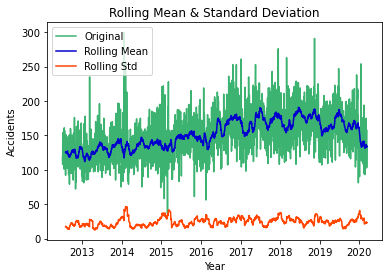

Test Statistic                   -2.995153
p-value                           0.035350
#Lags Used                       27.000000
Number of Observations Used    2783.000000
dtype: float64

In [6]:
# Visualize data, including 30-day rolling mean and standard deviation

roll_mean = df_prophet['y'].rolling(window=30, center=False).mean()
roll_std = df_prophet['y'].rolling(window=30, center=False).std()

plt.plot(df_prophet['y'],color='mediumseagreen', label='Original')
plt.plot(roll_mean, color='mediumblue', label='Rolling Mean')
plt.plot(roll_std, color='orangered', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.xlabel('Year')
plt.ylabel('Accidents')
plt.show(block=False)

# Dickey-Fuller test
test = adfuller(df_prophet['y'][1:-1])
dfoutput = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
dfoutput

Based on the above visualization and Dickey-Fuller p-value, we see that this data is stationary. We will therefore not perform differencing, a log transformation, or any other transformation on the data before fitting a model.

# Facebook Prophet Modeling

## Train-Test Split

In [7]:
# Train-test split
# 2019-06-06 will be the split point for our train and test sets, which is a 90%/10% split

X = df_prophet.index
y = df_prophet['y']

train = df_prophet.loc[:'2019-06-06']
test = df_prophet.loc['2019-06-07':]

X_train, X_test = train.index , test.index
y_train, y_test = train['y'] , test['y']

## Fit Model and Generate Predictions

In [8]:
# Fit model to data
model = Prophet(interval_width=0.95)
model.fit(train)

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [9]:
# Make predictions 1120 days into the future--ie until 6/30/22
# This way we will have a full year of model-predicted data after starting on 7/1/21
# Create future dates
future_dates = model.make_future_dataframe(periods=1120, freq='D')

# Generate predictions
forecast = model.predict(future_dates)
forecast.tail()

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
3647 2022-06-26  166.266090  103.155192  197.912590   149.215457   185.075716   
3648 2022-06-27  166.262032  132.490028  225.693150   149.186295   185.087733   
3649 2022-06-28  166.257975  133.130294  225.552157   149.157133   185.096355   
3650 2022-06-29  166.253917  132.031088  220.175509   149.127971   185.104976   
3651 2022-06-30  166.249860  129.301259  221.988028   149.098810   185.113597   

      additive_terms  additive_terms_lower  additive_terms_upper     weekly  \
3647      -15.519944            -15.519944            -15.519944 -24.184833   
3648       10.312050             10.312050             10.312050   2.620347   
3649       11.721278             11.721278             11.721278   5.049501   
3650        9.634522              9.634522              9.634522   4.011209   
3651        9.794627              9.794627              9.794627   5.229182   

      weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
3647    -24.184833    -24.184833  8.664889      8.664889      8.664889   
3648      2.620347      2.620347  7.691703      7.691703      7.691703   
3649      5.049501      5.049501  6.671777      6.671777      6.671777   
3650      4.011209      4.011209  5.623313      5.623313      5.623313   
3651      5.229182      5.229182  4.565445      4.565445      4.565445   

      multiplicative_terms  multiplicative_terms_lower  \
3647                   0.0                         0.0   
3648                   0.0                         0.0   
3649                   0.0                         0.0   
3650                   0.0                         0.0   
3651                   0.0                         0.0   

      multiplicative_terms_upper        yhat  
3647                         0.0  150.746146  
3648                         0.0  176.574083  
3649                         0.0  177.979253  
3650                         0.0  175.888439  
3651                         0.0  176.044487

## Visualize Model

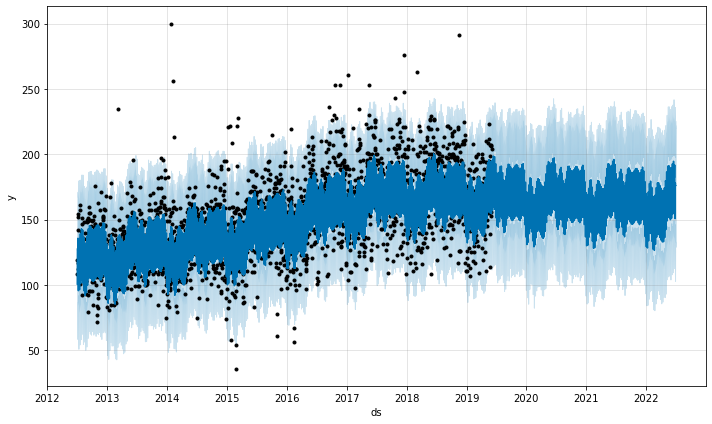

In [10]:
# Subset useful columns from forecast
forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Plot forecast
model.plot(forecast,uncertainty=True)
plt.show()

## Assess Model

In [11]:
# Assess model using RMSE to compare to our working ARIMA model
# Create RMSE function
def RMSE(pred):
    return np.sqrt(((pred-y_test)**2).mean())

# Define test predictions
test_preds = forecast.set_index('ds').loc['2019-06-07':'2020-03-13']

# Define fb prophet RMSE
fb_RMSE = RMSE(test_preds['yhat'])

# Compare to ARIMA RMSE to determine the better model
print('FB Prophet RMSE: ', fb_RMSE)
print('ARIMA RMSE: ', 29.630639592651963)

FB Prophet RMSE:  26.62053140392662
ARIMA RMSE:  29.630639592651963


Based on the above RMSEs, we see that our FB Prophet model performs 10% better than our ARIMA model. There is no need to adjust RMSE for range since these are based on the same test data.

In [17]:
# Although there is no need to view adjusted RMSE for purposes of comparing models,
# it is still helpful to see how well our model performed
print('Adjusted FB Prophet RMSE: ', fb_RMSE/(df_prophet.loc[:'2020-03-13']['y'].max()-df_prophet.loc[:'2020-03-13']['y'].min()))

Adjusted FB Prophet RMSE:  0.10083534622699478


## Adjust Predictions to Account for COVID

The above represents accident frequency predictions assuming the COVID-19 pandemic had not occured. Now we will adjust our predictions in the same way we did for our ARIMA model.

In [12]:
# Create Queens dataframe with all known data, not only pre-COVID
df_qns_total = df_TS.drop(columns = ['Injuries', 'Deaths','Accidents_Bx', 'Accidents_Man', 'Accidents_Bkln', 'Accidents_SI',
                               'Accidents_Total'])

# Create line connecting end of known data to predicted July data

# Begin model-based predictions on 7/1/21, diminish by 25%.
TS_pred_cov = forecast.set_index('ds').loc['2021-07-01':'2022-06-30']['yhat'] * 0.75

# Since there is more varibility in this model than there was in the ARIMA one and there is weekly seasonality,
# make 6/30/21 values the same as 7/7/2021 since they are the same day of the week
june_30 = TS_pred_cov.loc['2021-07-07']

# Create df for connection data
connection = pd.DataFrame(pd.date_range(start='2021-01-30', end='2021-06-30'))
connection['Date'] = pd.DataFrame(pd.date_range(start='2021-01-30', end='2021-06-30'))

# Find how much the accident count will rise each day
# There are 151 days between 1/29/21 and 6/30/21
daily_interval=(june_30 - df_qns_total['Accidents_Qns']['2021-01-29'])/151

# Add daily interval to each date in connection df
connection_forecasts = []
i = df_qns_total['Accidents_Qns']['2021-01-29']
for num in range(0,151):
    i+=daily_interval
    connection_forecasts.append(i)
    
# Add 6/30/21 to forecases
connection_forecasts.append(june_30)
    
# Add list of forecasts to connection df
connection['Forecast'] = connection_forecasts

# Make date index of connection df
connection.set_index('Date', inplace=True)
connection.drop(columns=0,inplace=True)

#Observe connection df
connection

Forecast
Date                  
2021-01-30   69.387741
2021-01-31   69.775483
2021-02-01   70.163224
2021-02-02   70.550966
2021-02-03   70.938707
...                ...
2021-06-26  126.385738
2021-06-27  126.773480
2021-06-28  127.161221
2021-06-29  127.548963
2021-06-30  127.548963

[152 rows x 1 columns]

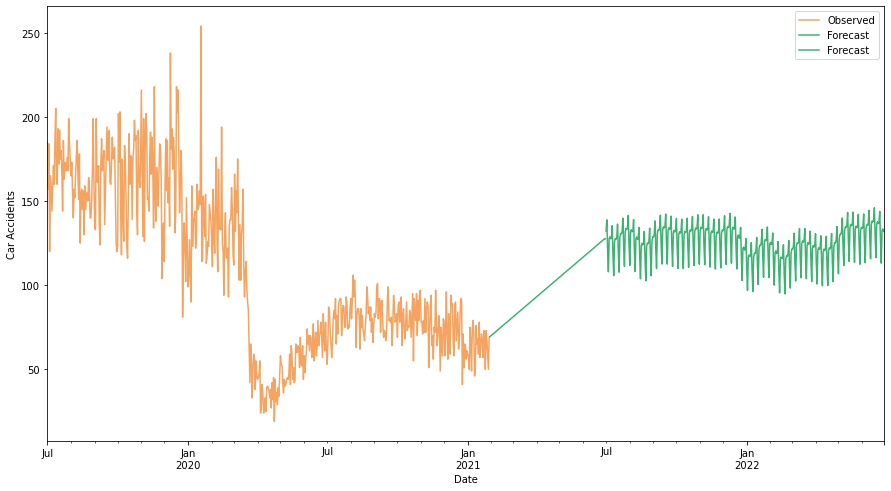

In [13]:
fix,ax = plt.subplots(figsize=(15,8))

# Plot known data
ax = df_qns_total['Accidents_Qns']['2019-07-01':].plot(label='Observed', color='sandybrown')

# Plot predicted data based on model, starting 7/1/20, 75% of model prediction
TS_pred_cov.plot(ax=ax, label='Forecast', color='mediumseagreen')

# Plot linear connection
connection.plot(ax=ax, color='mediumseagreen')

ax.set_xlabel('Date')
ax.set_ylabel('Car Accidents')

plt.legend()
plt.show()

Note we specifically did not include a confidence interval because this would be misleading given that it would not account for the uncertainty associated with the way we produced our predictions in regards to COVID-affected data.

# Export Data

In [15]:
# Create one df combining known and predicted accident frequencies
# Round forecasts to integers 
data_preds_qns = pd.concat([df_qns_total['Accidents_Qns'],round(connection['Forecast']),round(TS_pred_cov.astype(int))])


In [16]:
# Export data
data_preds_qns.to_csv('Data/data_preds_qns.csv')